In [1]:
test_set_perf <- read.csv('/home/jeremy/tornadoesr/data/raw/final_test_set_perf.csv')

old_df <- read.csv('/home/jeremy/tornadoesr/data/raw/tor_data_inflation_adj.csv')

lat_mu <- mean(old_df$BEGIN_LAT)
lat_sd <- sd(old_df$BEGIN_LAT)
lon_mu <- mean(old_df$BEGIN_LON)
lon_sd <- sd(old_df$BEGIN_LON)
dam_mu <- mean(log(old_df$DAMAGE_PROPERTY + 1))
dam_sd <- sd(log(old_df$DAMAGE_PROPERTY + 1))

test_set_perf$lat <- test_set_perf$lat*lat_sd+lat_mu
test_set_perf$lon <- test_set_perf$lon*lon_sd+lon_mu

test_set_perf$true <- exp(test_set_perf$true*dam_sd+dam_mu) - 1
test_set_perf$pred <- exp(test_set_perf$pred*dam_sd+dam_mu) - 1

head(test_set_perf)

X,true,pred,indicator,probs,dam_ind,jitter,lon,lat
0,141599.76,28787.56,black,0.83460754,1,0.06731716,-95.1000,38.6000
1,0.00,23314.01,red,0.02270062,0,0.19189214,-103.5800,39.7800
2,0.00,30166.88,red,0.96160350,0,0.16385760,-78.4700,33.9000
3,11441.85,27791.40,black,0.26483494,1,0.00595423,-99.6923,36.9503
4,10640.58,31224.17,black,0.19895664,1,0.04724601,-97.6640,32.5550
5,0.00,79254.77,red,0.94045730,0,0.07069670,-93.5780,36.6784


In [2]:
library(ggplot2)
library(raster)

Loading required package: sp


In [3]:
states <- map_data("state")

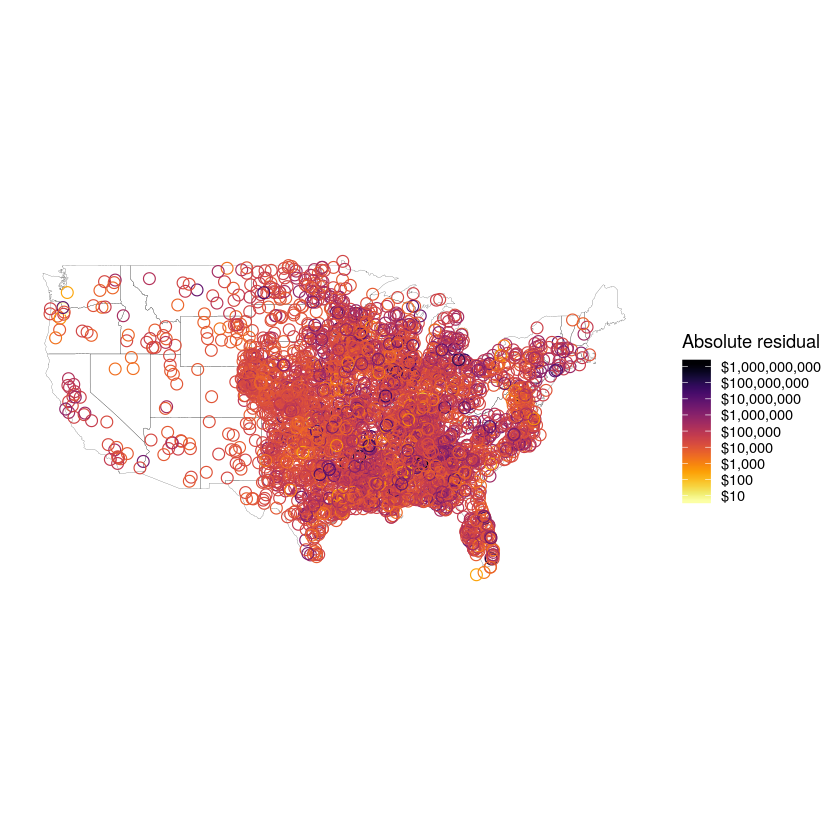

In [4]:
#png('maps/resid_test_points.png', height = 8, width = 8, units = 'in', res = 300)
ggplot(data = states) + 
  geom_polygon(aes(x = long, y = lat, group = group), color = "black", fill = 'NA', lwd = 0.05) +
  viridis::scale_color_viridis('Absolute residual',
                               breaks = c(1, 2, 3, 4, 5, 6, 7, 8, 9),
                               labels = c('$10', '$100', '$1,000', '$10,000', '$100,000', '$1,000,000', '$10,000,000', '$100,000,000', '$1,000,000,000'),
                               direction = -1, option = 'B') + 
  coord_quickmap() +
  guides(fill = FALSE) +
  geom_point(data = test_set_perf, aes(x = lon,
                                       y = lat,
                                       color = log10(sqrt((pred - true)**2) + 1)),
               size = 3, pch = 21, stroke = 0.5) +
  theme_minimal() +
  theme(panel.grid = element_blank(),
        axis.title = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank())
#dev.off()

In [5]:
library(akima)
library(reshape2)

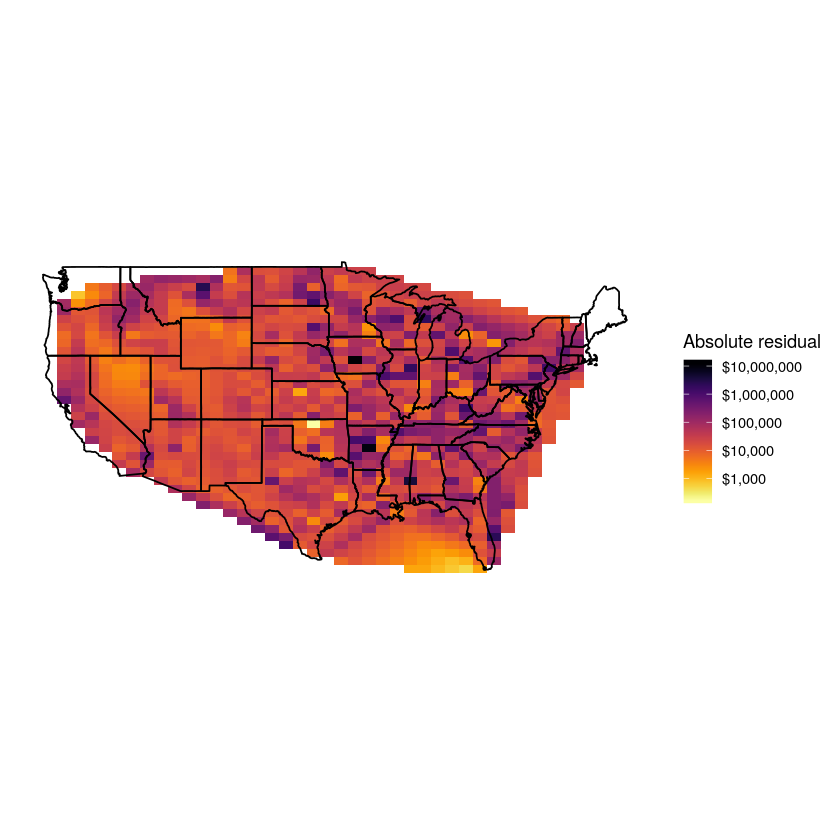

In [6]:
fld <- with(test_set_perf, interp(x = lon, y = lat, z = log10(sqrt((true - pred)^2) + 1), duplicate = 'mean'))

df <- melt(fld$z, na.rm = TRUE)
names(df) <- c("x", "y", "resid")
df$Lon <- fld$x[df$x]
df$Lat <- fld$y[df$y]
#png('maps/resid_test_interp.png', height = 8, width = 8, units = 'in', res = 300)
ggplot(data = states) + 
  coord_quickmap() +
  geom_tile(data = df, aes(x = Lon, y = Lat, fill = resid)) +
  geom_polygon(aes(x = long, y = lat, group = group), color = "black", fill = 'NA', lwd = 0.5) +
  viridis::scale_fill_viridis('Absolute residual',
                               breaks = c(1, 2, 3, 4, 5, 6, 7, 8, 9),
                               labels = c('$10', '$100', '$1,000', '$10,000', '$100,000', '$1,000,000', '$10,000,000', '$100,000,000', '$1,000,000,000'),
                               direction = -1, option = 'B') +
  viridis::scale_color_viridis(direction = -1, option = 'B') +
  theme_minimal() +
  theme(panel.grid = element_blank(),
        axis.title = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank())
#dev.off()

# Kansas

In [7]:
KS <- subset(states, region %in% c("kansas"))

In [8]:
KS_test_df <- dplyr::filter(test_set_perf, (min(KS$lat) - 1) <= lat &
                                          lat <= (max(KS$lat) + 1))
KS_test_df <- dplyr::filter(KS_test_df, (min(KS$long) - 1) <= lon &
                                         lon <= (max(KS$long) + 1))

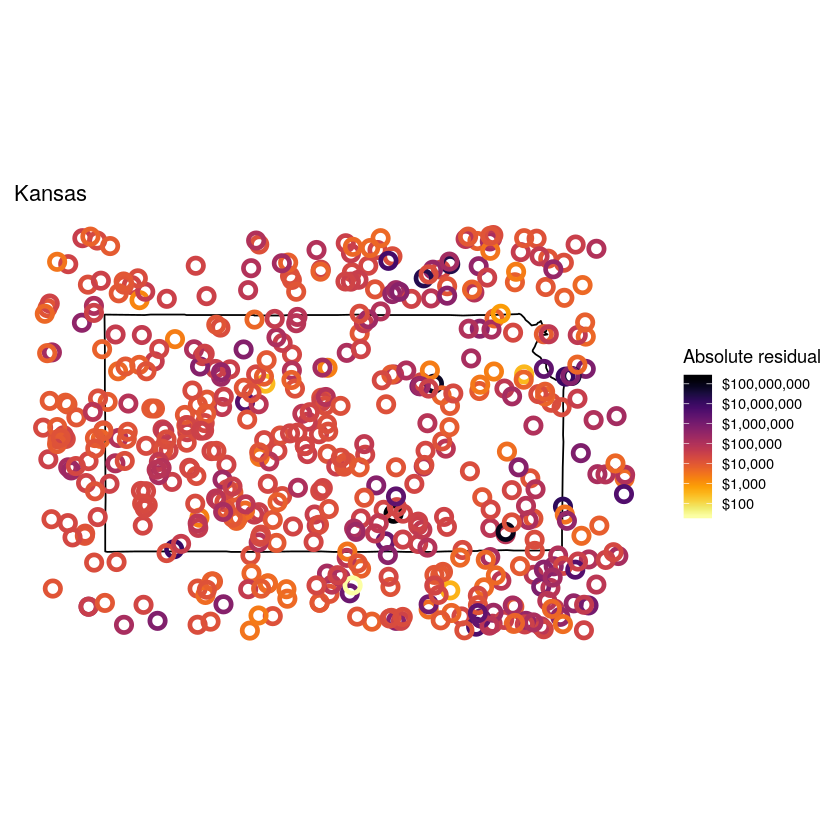

In [9]:
#png('maps/resid_test_points_KS.png', height = 8, width = 8, units = 'in', res = 300)
ggplot(data = KS) + 
  geom_polygon(aes(x = long, y = lat, group = group), color = "black", fill = 'NA', lwd = 0.5) +
  viridis::scale_color_viridis('Absolute residual',
                               breaks = c(1, 2, 3, 4, 5, 6, 7, 8, 9),
                               labels = c('$10', '$100', '$1,000', '$10,000', '$100,000', '$1,000,000', '$10,000,000', '$100,000,000', '$1,000,000,000'),
                               direction = -1, option = 'B') + 
  coord_quickmap() +
  guides(fill = FALSE) +
  geom_point(data = KS_test_df, aes(x = lon,
                                       y = lat,
                                       color = log10(sqrt((pred - true)**2) + 1)),
               size = 3, pch = 21, stroke = 2) +
  theme_minimal() +
  theme(panel.grid = element_blank(),
        axis.title = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank()) +
  xlim(min(KS$long) - 1, max(KS$long) + 1) +
  ylim(min(KS$lat) - 1, max(KS$lat) + 1) +
  labs(title = 'Kansas')
#dev.off()

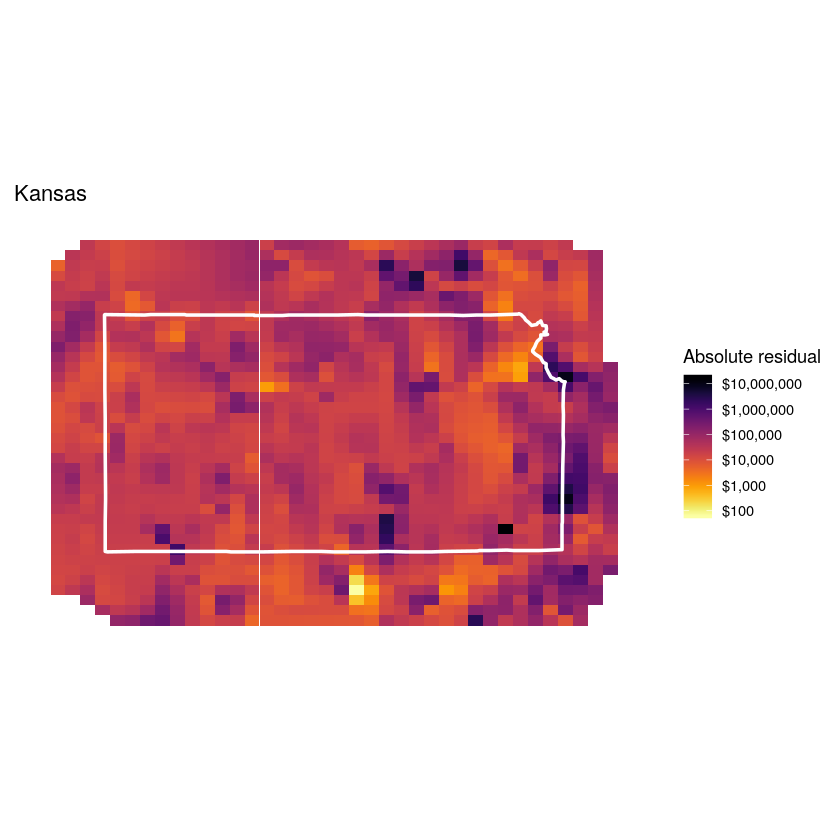

In [10]:
fld <- with(KS_test_df, interp(x = lon, y = lat, z = log10(sqrt((true - pred)^2) + 1), duplicate = 'mean'))

df <- melt(fld$z, na.rm = TRUE)
names(df) <- c("x", "y", "resid")
df$Lon <- fld$x[df$x]
df$Lat <- fld$y[df$y]
#png('maps/resid_test_interp_KS.png', height = 8, width = 8, units = 'in', res = 300)
ggplot(data = KS) + 
  coord_quickmap() +
  geom_tile(data = df, aes(x = Lon, y = Lat, fill = resid)) +
  geom_polygon(aes(x = long, y = lat, group = group), color = "white", fill = 'NA', lwd = 1) +
  viridis::scale_fill_viridis('Absolute residual',
                               breaks = c(1, 2, 3, 4, 5, 6, 7, 8, 9),
                               labels = c('$10', '$100', '$1,000', '$10,000', '$100,000', '$1,000,000', '$10,000,000', '$100,000,000', '$1,000,000,000'),
                               direction = -1, option = 'B') +
  theme_minimal() +
  theme(panel.grid = element_blank(),
        axis.title = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank()) +
  xlim(min(KS$long) - 1, max(KS$long) + 1) +
  ylim(min(KS$lat) - 1, max(KS$lat) + 1) +
  labs(title = 'Kansas')
#dev.off()

# Illinois

In [11]:
IL <- subset(states, region %in% c("illinois"))

In [12]:
IL_test_df <- dplyr::filter(test_set_perf, (min(IL$lat) - 1) <= lat &
                                          lat <= (max(IL$lat) + 1))
IL_test_df <- dplyr::filter(IL_test_df, (min(IL$long) - 1) <= lon &
                                         lon <= (max(IL$long) + 1))

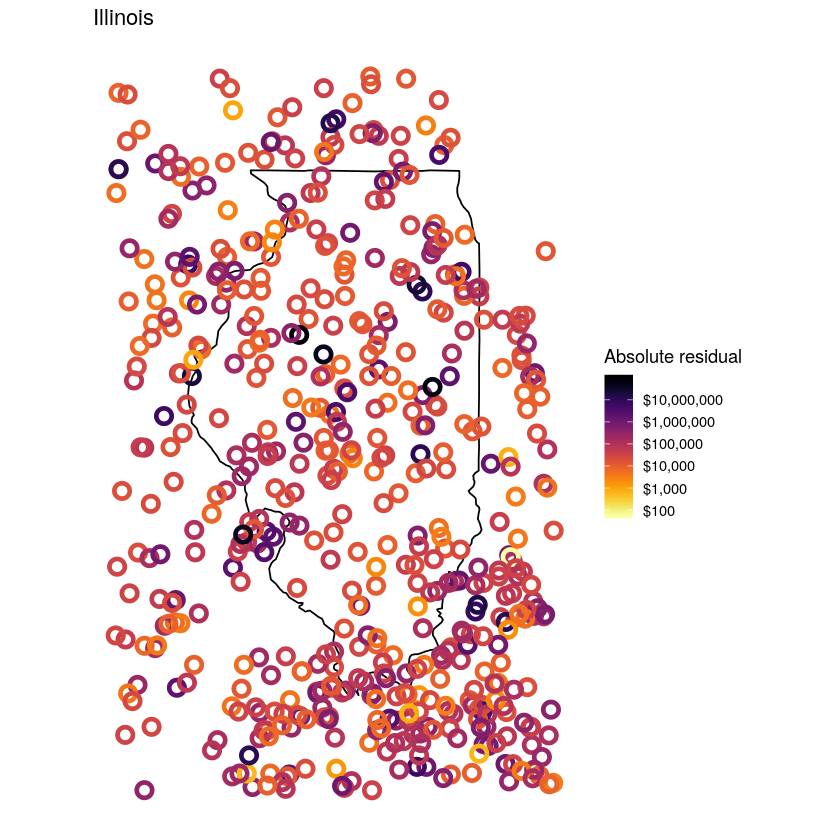

In [13]:
#png('maps/resid_test_points_IL.png', height = 8, width = 8, units = 'in', res = 300)
ggplot(data = IL) + 
  geom_polygon(aes(x = long, y = lat, group = group), color = "black", fill = 'NA', lwd = 0.5) +
  viridis::scale_color_viridis('Absolute residual',
                               breaks = c(1, 2, 3, 4, 5, 6, 7, 8, 9),
                               labels = c('$10', '$100', '$1,000', '$10,000', '$100,000', '$1,000,000', '$10,000,000', '$100,000,000', '$1,000,000,000'),
                               direction = -1, option = 'B') + 
  coord_quickmap() +
  guides(fill = FALSE) +
  geom_point(data = IL_test_df, aes(x = lon,
                                       y = lat,
                                       color = log10(sqrt((pred - true)**2) + 1)),
               size = 3, pch = 21, stroke = 2) +
  theme_minimal() +
  theme(panel.grid = element_blank(),
        axis.title = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank()) +
  xlim(min(IL$long) - 1, max(IL$long) + 1) +
  ylim(min(IL$lat) - 1, max(IL$lat) + 1) +
  labs(title = 'Illinois')
#dev.off()

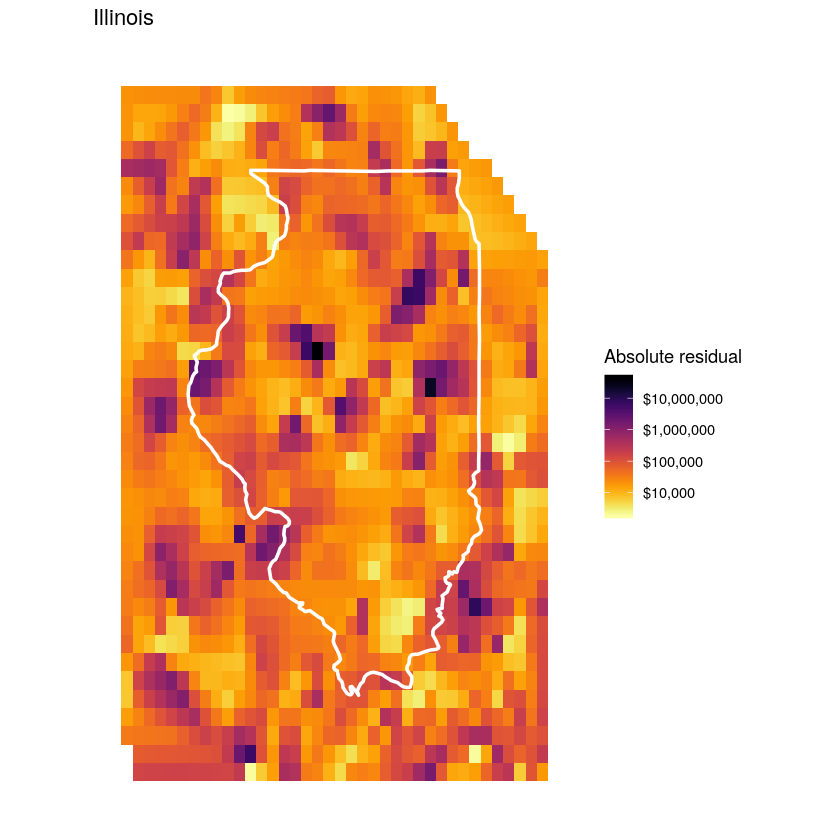

In [14]:
fld <- with(IL_test_df, interp(x = lon, y = lat, z = log10(sqrt((true - pred)^2) + 1), duplicate = 'mean'))

df <- melt(fld$z, na.rm = TRUE)
names(df) <- c("x", "y", "resid")
df$Lon <- fld$x[df$x]
df$Lat <- fld$y[df$y]
#png('maps/resid_test_interp_IL.png', height = 8, width = 8, units = 'in', res = 300)
ggplot(data = IL) + 
  coord_quickmap() +
  geom_tile(data = df, aes(x = Lon, y = Lat, fill = resid)) +
  geom_polygon(aes(x = long, y = lat, group = group), color = "white", fill = 'NA', lwd = 1) +
  viridis::scale_fill_viridis('Absolute residual',
                               breaks = c(1, 2, 3, 4, 5, 6, 7, 8, 9),
                               labels = c('$10', '$100', '$1,000', '$10,000', '$100,000', '$1,000,000', '$10,000,000', '$100,000,000', '$1,000,000,000'),
                               direction = -1, option = 'B') +
  theme_minimal() +
  theme(panel.grid = element_blank(),
        axis.title = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank()) +
  xlim(min(IL$long) - 1, max(IL$long) + 1) +
  ylim(min(IL$lat) - 1, max(IL$lat) + 1) +
  labs(title = 'Illinois')
#dev.off()

# Alabama

In [15]:
AL <- subset(states, region %in% c("alabama"))

In [16]:
AL_test_df <- dplyr::filter(test_set_perf, (min(AL$lat) - 1) <= lat &
                                          lat <= (max(AL$lat) + 1))
AL_test_df <- dplyr::filter(AL_test_df, (min(AL$long) - 1) <= lon &
                                         lon <= (max(AL$long) + 1))

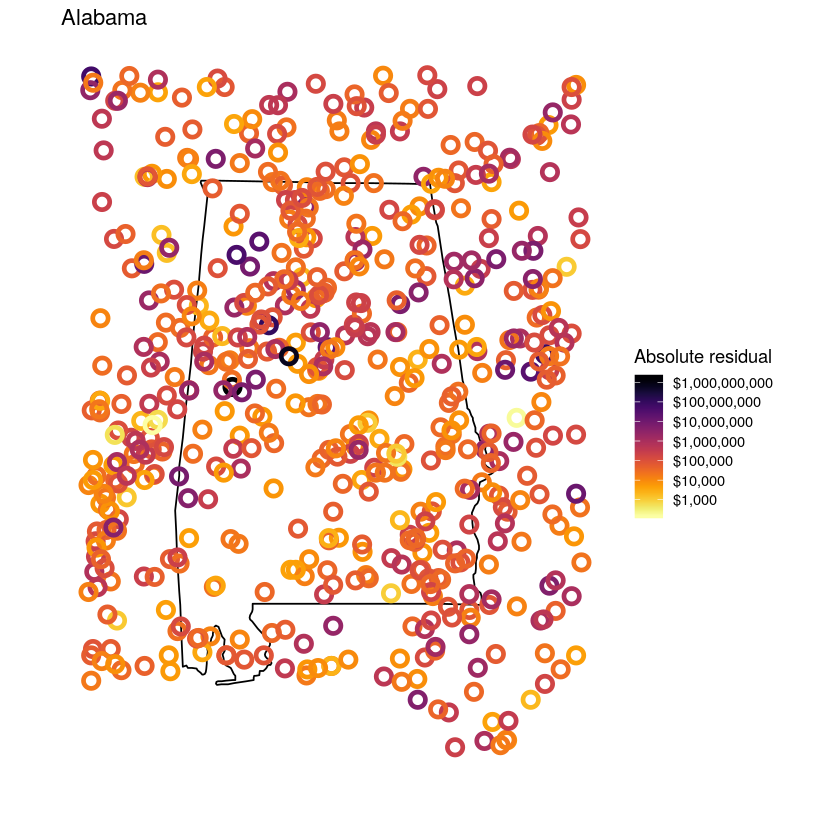

In [17]:
#png('maps/resid_test_points_AL.png', height = 8, width = 8, units = 'in', res = 300)
ggplot(data = AL) + 
  geom_polygon(aes(x = long, y = lat, group = group), color = "black", fill = 'NA', lwd = 0.5) +
  viridis::scale_color_viridis('Absolute residual',
                               breaks = c(1, 2, 3, 4, 5, 6, 7, 8, 9),
                               labels = c('$10', '$100', '$1,000', '$10,000', '$100,000', '$1,000,000', '$10,000,000', '$100,000,000', '$1,000,000,000'),
                               direction = -1, option = 'B') + 
  coord_quickmap() +
  guides(fill = FALSE) +
  geom_point(data = AL_test_df, aes(x = lon,
                                       y = lat,
                                       color = log10(sqrt((pred - true)**2) + 1)),
               size = 3, pch = 21, stroke = 2) +
  theme_minimal() +
  theme(panel.grid = element_blank(),
        axis.title = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank()) +
  xlim(min(AL$long) - 1, max(AL$long) + 1) +
  ylim(min(AL$lat) - 1, max(AL$lat) + 1) +
  labs(title = 'Alabama')
#dev.off()

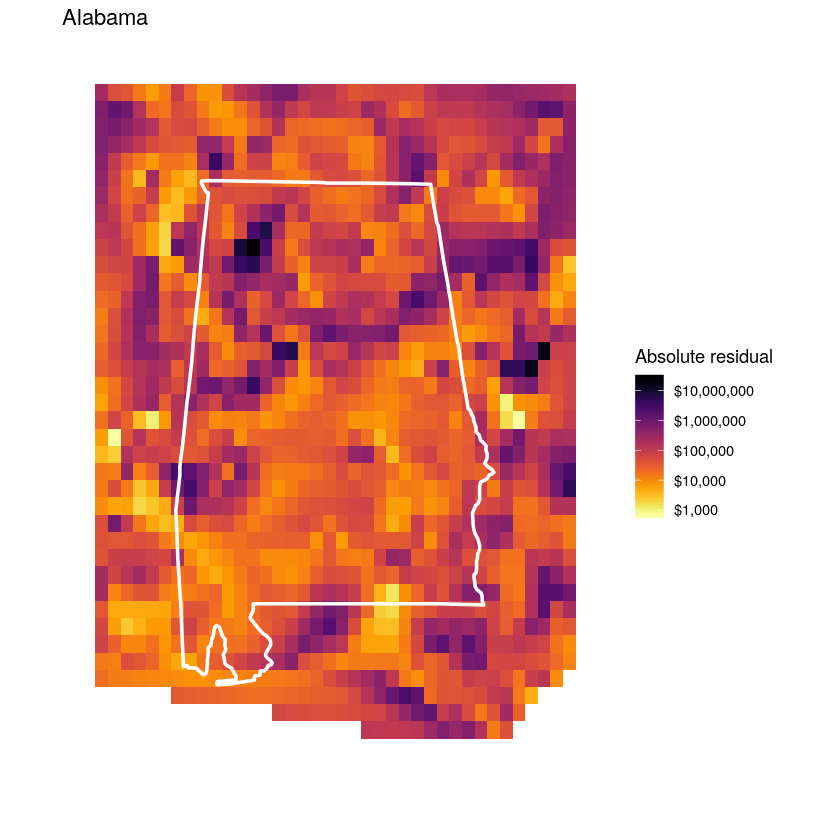

In [18]:
fld <- with(AL_test_df, interp(x = lon, y = lat, z = log10(sqrt((true - pred)^2) + 1), duplicate = 'mean'))

df <- melt(fld$z, na.rm = TRUE)
names(df) <- c("x", "y", "resid")
df$Lon <- fld$x[df$x]
df$Lat <- fld$y[df$y]
#png('maps/resid_test_interp_AL.png', height = 8, width = 8, units = 'in', res = 300)
ggplot(data = AL) + 
  coord_quickmap() +
  geom_tile(data = df, aes(x = Lon, y = Lat, fill = resid)) +
  geom_polygon(aes(x = long, y = lat, group = group), color = "white", fill = 'NA', lwd = 1) +
  viridis::scale_fill_viridis('Absolute residual',
                               breaks = c(1, 2, 3, 4, 5, 6, 7, 8, 9),
                               labels = c('$10', '$100', '$1,000', '$10,000', '$100,000', '$1,000,000', '$10,000,000', '$100,000,000', '$1,000,000,000'),
                               direction = -1, option = 'B') +
  theme_minimal() +
  theme(panel.grid = element_blank(),
        axis.title = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank()) +
  xlim(min(AL$long) - 1, max(AL$long) + 1) +
  ylim(min(AL$lat) - 1, max(AL$lat) + 1) +
  labs(title = 'Alabama')
#dev.off()

# Tennessee

In [19]:
TN <- subset(states, region %in% c("tennessee"))

In [20]:
TN_test_df <- dplyr::filter(test_set_perf, (min(TN$lat) - 1) <= lat &
                                          lat <= (max(TN$lat) + 1))
TN_test_df <- dplyr::filter(TN_test_df, (min(TN$long) - 1) <= lon &
                                         lon <= (max(TN$long) + 1))

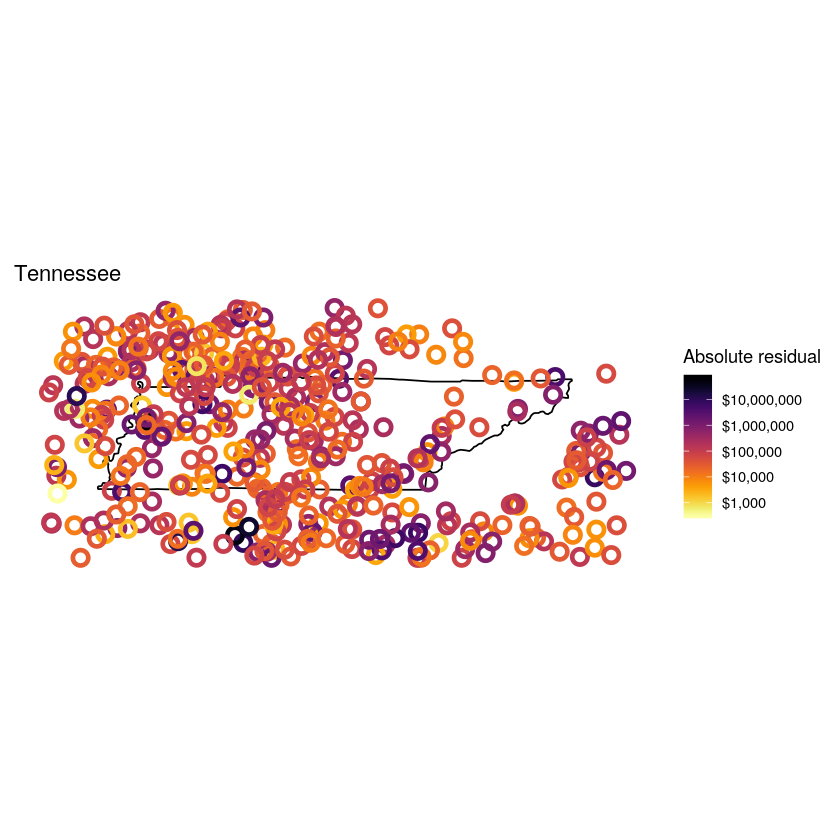

In [21]:
#png('maps/resid_test_points_TN.png', height = 8, width = 8, units = 'in', res = 300)
ggplot(data = TN) + 
  geom_polygon(aes(x = long, y = lat, group = group), color = "black", fill = 'NA', lwd = 0.5) +
  viridis::scale_color_viridis('Absolute residual',
                               breaks = c(1, 2, 3, 4, 5, 6, 7, 8, 9),
                               labels = c('$10', '$100', '$1,000', '$10,000', '$100,000', '$1,000,000', '$10,000,000', '$100,000,000', '$1,000,000,000'),
                               direction = -1, option = 'B') + 
  coord_quickmap() +
  guides(fill = FALSE) +
  geom_point(data = TN_test_df, aes(x = lon,
                                       y = lat,
                                       color = log10(sqrt((pred - true)**2) + 1)),
               size = 3, pch = 21, stroke = 2) +
  theme_minimal() +
  theme(panel.grid = element_blank(),
        axis.title = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank()) +
  xlim(min(TN$long) - 1, max(TN$long) + 1) +
  ylim(min(TN$lat) - 1, max(TN$lat) + 1) +
  labs(title = 'Tennessee')
#dev.off()

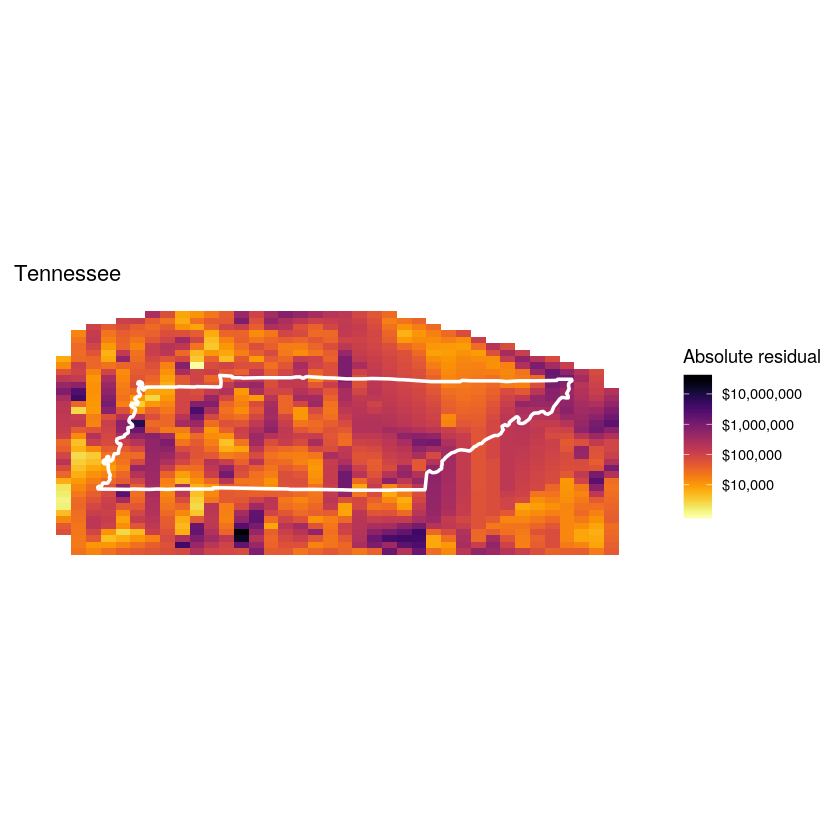

In [22]:
fld <- with(TN_test_df, interp(x = lon, y = lat, z = log10(sqrt((true - pred)^2) + 1), duplicate = 'mean'))

df <- melt(fld$z, na.rm = TRUE)
names(df) <- c("x", "y", "resid")
df$Lon <- fld$x[df$x]
df$Lat <- fld$y[df$y]
#png('maps/resid_test_interp_TN.png', height = 8, width = 8, units = 'in', res = 300)
ggplot(data = TN) + 
  coord_quickmap() +
  geom_tile(data = df, aes(x = Lon, y = Lat, fill = resid)) +
  geom_polygon(aes(x = long, y = lat, group = group), color = "white", fill = 'NA', lwd = 1) +
  viridis::scale_fill_viridis('Absolute residual',
                               breaks = c(1, 2, 3, 4, 5, 6, 7, 8, 9),
                               labels = c('$10', '$100', '$1,000', '$10,000', '$100,000', '$1,000,000', '$10,000,000', '$100,000,000', '$1,000,000,000'),
                               direction = -1, option = 'B') +
  theme_minimal() +
  theme(panel.grid = element_blank(),
        axis.title = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank()) +
  xlim(min(TN$long) - 1, max(TN$long) + 1) +
  ylim(min(TN$lat) - 1, max(TN$lat) + 1) +
  labs(title = 'Tennessee')
#dev.off()

# Florida

In [23]:
FL <- subset(states, region %in% c("florida"))

In [24]:
FL_test_df <- dplyr::filter(test_set_perf, (min(FL$lat) - 1) <= lat &
                                          lat <= (max(FL$lat) + 1))
FL_test_df <- dplyr::filter(FL_test_df, (min(FL$long) - 1) <= lon &
                                         lon <= (max(FL$long) + 1))

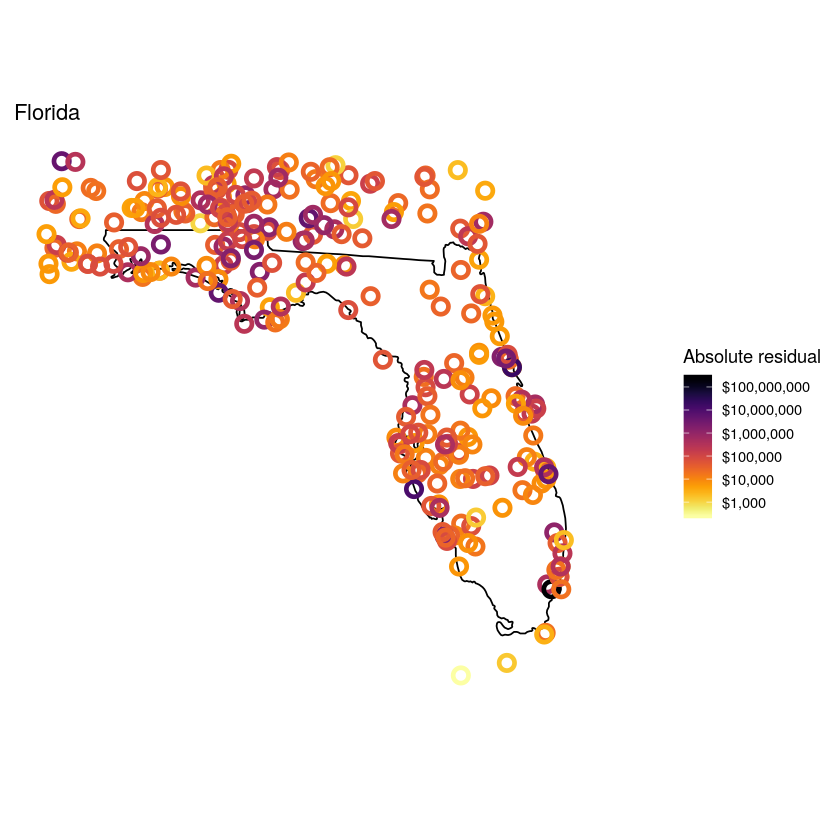

In [25]:
#png('maps/resid_test_points_FL.png', height = 8, width = 8, units = 'in', res = 300)
ggplot(data = FL) + 
  geom_polygon(aes(x = long, y = lat, group = group), color = "black", fill = 'NA', lwd = 0.5) +
  viridis::scale_color_viridis('Absolute residual',
                               breaks = c(1, 2, 3, 4, 5, 6, 7, 8, 9),
                               labels = c('$10', '$100', '$1,000', '$10,000', '$100,000', '$1,000,000', '$10,000,000', '$100,000,000', '$1,000,000,000'),
                               direction = -1, option = 'B') + 
  coord_quickmap() +
  guides(fill = FALSE) +
  geom_point(data = FL_test_df, aes(x = lon,
                                       y = lat,
                                       color = log10(sqrt((pred - true)**2) + 1)),
               size = 3, pch = 21, stroke = 2) +
  theme_minimal() +
  theme(panel.grid = element_blank(),
        axis.title = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank()) +
  xlim(min(FL$long) - 1, max(FL$long) + 1) +
  ylim(min(FL$lat) - 1, max(FL$lat) + 1) +
  labs(title = 'Florida')
#dev.off()

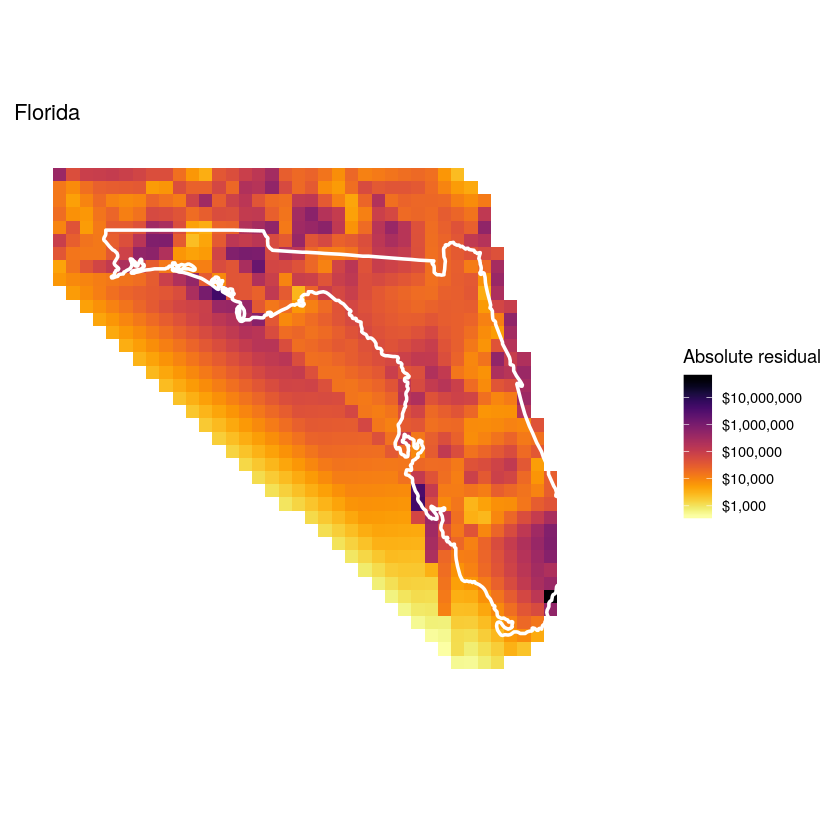

In [26]:
fld <- with(FL_test_df, interp(x = lon, y = lat, z = log10(sqrt((true - pred)^2) + 1), duplicate = 'mean'))

df <- melt(fld$z, na.rm = TRUE)
names(df) <- c("x", "y", "resid")
df$Lon <- fld$x[df$x]
df$Lat <- fld$y[df$y]
#png('maps/resid_test_interp_FL.png', height = 8, width = 8, units = 'in', res = 300)
ggplot(data = FL) + 
  coord_quickmap() +
  geom_tile(data = df, aes(x = Lon, y = Lat, fill = resid)) +
  geom_polygon(aes(x = long, y = lat, group = group), color = "white", fill = 'NA', lwd = 1) +
  viridis::scale_fill_viridis('Absolute residual',
                               breaks = c(1, 2, 3, 4, 5, 6, 7, 8, 9),
                               labels = c('$10', '$100', '$1,000', '$10,000', '$100,000', '$1,000,000', '$10,000,000', '$100,000,000', '$1,000,000,000'),
                               direction = -1, option = 'B') +
  theme_minimal() +
  theme(panel.grid = element_blank(),
        axis.title = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank()) +
  xlim(min(FL$long) - 1, max(FL$long) + 1) +
  ylim(min(FL$lat) - 1, max(FL$lat) + 1) +
  labs(title = 'Florida')
#dev.off()